In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
X, y = load_svmlight_file('a.txt')
X_dense = X.toarray()
X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.3, random_state=42)
X_train, X_test = torch.FloatTensor(X_train).to(device), torch.FloatTensor(X_test).to(device)
y_train, y_test = torch.FloatTensor(y_train).unsqueeze(1).to(device), torch.FloatTensor(y_test).unsqueeze(1).to(device)
y_train = (y_train + 1) / 2  
y_test = (y_test + 1) / 2  

# Hyperparameters space
optimizers = [
    optim.SGD,
    optim.Adam,
    optim.RMSprop,
    optim.Adagrad,
    optim.Adadelta,
    optim.Adamax
]
activation_functions = {
    'sigmoid': nn.Sigmoid(),
    'relu': nn.ReLU(),
    'elu': nn.ELU(),
    'tanh': nn.Tanh()
}
learning_rates = [0.0001, 0.001, 0.01, 0.1]
weight_decays = [0.0, 0.001, 0.01, 0.1]
lambdas = [0.0, 0.001, 0.01, 0.1]
dropout_probs = [0.0, 0.2, 0.4, 0.6]

def build_model(input_dim, hidden_layers, neurons_per_layer, activation_func, dropout_prob):
    layers = []
    for i in range(hidden_layers):
        layers.append(nn.Linear(input_dim if i == 0 else neurons_per_layer, neurons_per_layer))
        layers.append(activation_functions[activation_func])
        if i != hidden_layers - 1:  
            layers.append(nn.Dropout(p=dropout_prob))
    layers.append(nn.Linear(neurons_per_layer, 1))
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

param_grid = {
    'hidden_layers': [1, 2, 3, 4],
    'neurons_per_layer': [10,20,30,40,50,60],
    'lr': [0.01, 0.001],
    'optimizer': optimizers,
    'weight_decay': [0, 0.01],
    'l1_lambda': lambdas,  
    'activation_func': ['sigmoid', 'relu', 'elu', 'tanh'],
    'dropout_prob': dropout_probs
}

results = []
n_iter_search = 30 
early_stopping_patience = 10  

for params in ParameterSampler(param_grid, n_iter=n_iter_search, random_state=0):
    model = build_model(X_train.shape[1], params['hidden_layers'], params['neurons_per_layer'], params['activation_func'], params['dropout_prob'])
    criterion = nn.BCELoss()
    optimizer = params['optimizer'](model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    
    best_loss = np.inf
    no_improve_count = 0
    

    num_epochs = 50 
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if loss.item() < best_loss:
            best_loss = loss.item()
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= early_stopping_patience:
                break
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        predicted_labels = (test_outputs > 0.5).float()
        test_accuracy = (predicted_labels == y_test).float().mean()
        results.append({
            'params': params,
            'test_loss': test_loss.item(),
            'test_accuracy': test_accuracy.item()
        })
results.sort(key=lambda x: x['test_accuracy'], reverse=True)
for res in results:
    print(f"Test Loss: {res['test_loss']:.4f}, Test Accuracy: {res['test_accuracy']:.4f}, Parameters: {res['params']}")
best_result = results[0]
print("\nBest Result:")
print(f"Test Loss: {best_result['test_loss']:.4f}, Test Accuracy: {best_result['test_accuracy']:.4f}, Parameters: {best_result['params']}")


Test Loss: 0.5047, Test Accuracy: 0.7403, Parameters: {'weight_decay': 0.01, 'optimizer': <class 'torch.optim.adam.Adam'>, 'neurons_per_layer': 50, 'lr': 0.01, 'l1_lambda': 0.01, 'hidden_layers': 1, 'dropout_prob': 0.2, 'activation_func': 'relu'}
Test Loss: 0.5214, Test Accuracy: 0.7359, Parameters: {'weight_decay': 0.01, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'neurons_per_layer': 50, 'lr': 0.01, 'l1_lambda': 0.01, 'hidden_layers': 1, 'dropout_prob': 0.6, 'activation_func': 'relu'}
Test Loss: 0.5197, Test Accuracy: 0.7359, Parameters: {'weight_decay': 0.01, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'neurons_per_layer': 20, 'lr': 0.01, 'l1_lambda': 0.0, 'hidden_layers': 1, 'dropout_prob': 0.2, 'activation_func': 'relu'}
Test Loss: 0.5310, Test Accuracy: 0.7273, Parameters: {'weight_decay': 0, 'optimizer': <class 'torch.optim.adam.Adam'>, 'neurons_per_layer': 60, 'lr': 0.01, 'l1_lambda': 0.1, 'hidden_layers': 1, 'dropout_prob': 0.6, 'activation_func': 'sigmoid'}
Te

In [12]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
best_params = best_result['params']
model = build_model(
    X_train.shape[1],
    best_params['hidden_layers'],
    best_params['neurons_per_layer'],
    best_params['activation_func'],
    best_params['dropout_prob']
).to(device)
optimizer = best_params['optimizer'](model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = nn.BCELoss()
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
print(model)
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    predicted_labels = (test_outputs > 0.5).float()
    mlp_accuracy = accuracy_score(y_test.cpu().numpy(), predicted_labels.cpu().numpy())

print(f"Test Loss using best hyperparameters: {test_loss.item():.4f}")
print(f"Test Accuracy using best hyperparameters: {mlp_accuracy:.4f}")

Sequential(
  (0): Linear(in_features=8, out_features=50, bias=True)
  (1): ELU(alpha=1.0)
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ELU(alpha=1.0)
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): ELU(alpha=1.0)
  (8): Linear(in_features=50, out_features=1, bias=True)
  (9): Sigmoid()
)
Test Loss using best hyperparameters: 0.5119
Test Accuracy using best hyperparameters: 0.7359


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
    def forward(self, x):
        return torch.sigmoid(self.fc(x))
input_dim = X_train.shape[1]
model = Perceptron(input_dim).to(device)
criterion = nn.BCELoss()  
optimizer = optim.SGD(model.parameters(), lr=0.01) 
num_epochs = 50
for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')
with torch.no_grad():
    test_outputs = model(X_test)
    percept_loss = criterion(test_outputs, y_test)
    predicted = (test_outputs >= 0.5).float()
    percept_accuracy = (predicted == y_test).float().mean()
    print(f"Test Loss: {percept_loss.item():.4f}")
    print(f"Accuracy: {percept_accuracy.item() * 100:.2f}%")

Epoch [10/50], Training Loss: 0.7745
Epoch [20/50], Training Loss: 0.7503
Epoch [30/50], Training Loss: 0.7296
Epoch [40/50], Training Loss: 0.7118
Epoch [50/50], Training Loss: 0.6966
Test Loss: 0.7009
Accuracy: 47.62%


In [3]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score,log_loss
X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.2, random_state=42)
svc = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [1, 0.1, 0.01, 0.001]
}
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)
y_pred_proba = best_svc.predict_proba(X_test)[:, 1] 
accuracy = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_pred_proba)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"SVM Accuracy: {accuracy:.4f}")
print(f"SVM loss: {loss:.4f}")

Best Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Accuracy: 0.7727
SVM loss: 0.5018


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
dt = DecisionTreeClassifier()
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
y_pred_proba_dt = best_dt.predict_proba(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
loss_dt = log_loss(y_test, y_pred_proba_dt)
print(f"Best Parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print(f"Decision Tree Log Loss: {loss_dt:.4f}")

Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Decision Tree Accuracy: 0.7338
Decision Tree Log Loss: 3.8351


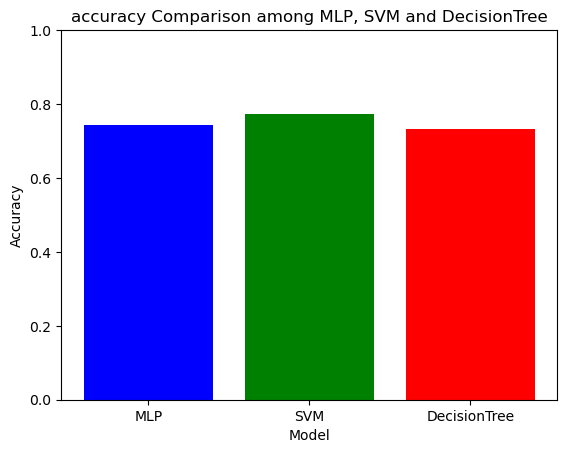

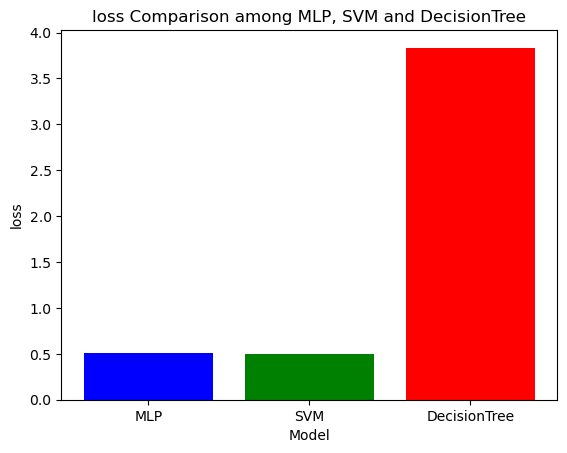

In [5]:
import matplotlib.pyplot as plt
svm_accuracy = accuracy
labels = ['MLP', 'SVM','DecisionTree','Perceptron']
accuracies = [mlp_accuracy, svm_accuracy,accuracy_dt,]
plt.bar(labels, accuracies, color=['blue', 'green','red','yellow'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('accuracy Comparison among MLP, SVM, DecisionTree and perceptron')
plt.ylim([0, 1])
plt.show()
labels = ['MLP', 'SVM','DecisionTree','Perceptron']
losses = [test_loss.item(), loss,loss_dt]
plt.bar(labels, losses, color=['blue', 'green','red','yellow'])
plt.xlabel('Model')
plt.ylabel('loss')
plt.title('loss Comparison among MLP, SVM, DecisionTree and perceptron')
plt.show()